In [193]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
class Features():
    def __init__(self):
        self.feature_matrix = []

    def get_feature_matrix(self, n_actions, observation):
        try:
           observation = self.transform_to_polynomial_basis(observation).flatten()
        except Exception as e:
           print("polynomial fit error")
           raise e
        observation = self.get_min_max_scaler(observation).flatten()
        num_obs = len(observation)
        features = []
        for j in range(n_actions):
          feature = [[None]*num_obs]*n_actions
          feature[j] = observation
          for i in range(j, n_actions-1+j):
            feature[(i+1)%n_actions] = np.zeros(num_obs)
          feature = np.array(feature).flatten()
          feature = np.append(feature, [1])
          features.append(np.array(feature).flatten())
        return features
    
    def get_min_max_scaler(self, observation):
      feature=[]
      feature = np.append(observation, feature).reshape(-1,1)
      scaler = MinMaxScaler(feature_range=(-1,1)).fit(np.array(feature))
      scaled = scaler.transform(feature)
      return scaled.flatten()
    
    def transform_to_fourier_basis(self, observation):
      return poly.fit_transform(observation)
    
    def transform_to_polynomial_basis(self, observation):
      poly = PolynomialFeatures(degree=2, include_bias=False)
      return poly.fit_transform([observation])

f = np.array([2,3,4])
Features().get_feature_matrix(2, f)

[array([-1.        , -0.85714286, -0.71428571, -0.71428571, -0.42857143,
        -0.14285714,  0.        ,  0.42857143,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ]),
 array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -1.        ,
        -0.85714286, -0.71428571, -0.71428571, -0.42857143, -0.14285714,
         0.        ,  0.42857143,  1.        ,  1.        ])]

In [160]:
a = np.array([2,3,4])
b = np.append(a,1)
print(b)

[2 3 4 1]


In [256]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from gym.wrappers.monitoring.video_recorder import VideoRecorder


# class Features():
#     def __init__(self):
#         self.feature_matrix = []

#     def get_feature_matrix(self, n_actions, observation):
#         observation = self.get_engineered_feature(observation)
#         num_obs = len(observation)
#         features = []
#         for j in range(n_actions):
#           feature = [[None]*num_obs]*n_actions
#           feature[j] = observation
#           for i in range(j, n_actions-1+j):
#             feature[(i+1)%n_actions] = np.zeros(num_obs)
#           features.append(np.array(feature).flatten())
#         self.feature_matrix = features
    
#     # def get_action(self, observation):
#     #     features =self.get_feature_matrix(observation)
#     #     action = np.argmax([feature for feature in features])
#     #     delta = reward + self.gamma*max([feature for feature in features])
#     #     self.w = (1-self.alpha)*(self.w) + self.alpha*(features[action]*delta) 

#     def get_engineered_feature(self, observation):
#       return observation
    
class CartPoleEnvLinear(gym.Env):

    metadata = {"render.modes": ["human", "rgb_array"], "video.frames_per_second": 50}

    def __init__(self, render_mode="rgb_array", n_observations=1000, q_table=np.array(None), alpha=0.9):
      self.env = gym.make("CartPole-v1", render_mode=render_mode)
      self.action_space = self.env.action_space
      self.n_actions = 2
      self.observation_space = self.env.observation_space
      self.n_observation_space = 15
      self.n_buckets = 4
      self.bucket_size = self.env.observation_space.high / (self.n_buckets/2)
      # self.q_table =  np.zeros((self.env.action_space.n, np.power(self.n_buckets, self.n_observation_space))) if not q_table.all() else q_table
      self.epsilon = n_observations/2
      self.n_observations = n_observations
      self.epsilon_delta = self.epsilon / self.n_observations
      self.metric = []
      self.test_metric = []
      self.alpha = alpha
      self.gamma =  0.2
      self.features = Features()
      self.n_observation_space = len(self.features.get_feature_matrix(1,self.observation_space.sample())[0])
      print(f"{self.n_observation_space=}")
      self.w = np.ones(self.n_observation_space*2-1)
      self.epsilon_greedy_curve = []
      self.converged = False
      return 
    
    def get_index(self, observation):
      observation_bucketed = self.bucket_observation(observation)
      i = len(observation_bucketed) - 1
      idx = 0
      for el in observation_bucketed:
        idx = idx + (self.n_buckets**i * el)
        i -= 1
      return int(idx)
    
    def bucket_observation(self, observation):
      return(np.floor(observation/self.bucket_size))

    def update_q_table(self, observation, observation_prime, reward, action=1):
        action, features = self.get_action(observation=observation)
        max_future_reward = self.get_max_future_reward(observation=observation_prime)
        # print(f"{max_future_reward=}")
        delta = reward + self.gamma*max_future_reward
        # print(f"{delta=}")
        self.w = (1-self.alpha)*(self.w) + self.alpha*(features[action]*delta)
        # print(f"{self.w=}")

    def get_action(self, observation):
       features = self.features.get_feature_matrix(n_actions=self.n_actions, observation=observation)
       action = np.argmax([feature.dot(self.w) for feature in features])
       return action, features
    

    def get_max_future_reward(self, observation):
      features = self.features.get_feature_matrix(n_actions=self.n_actions, observation=observation)
      max_reward = np.max([feature.dot(self.w) for feature in features])
      return max_reward

    def policy(self, observation):   
      prob = self.get_epsilon_greedy_probability() #at first, low probability to read from q-table, ie high prob take random action
      take_random_action = prob < np.random.random()
      if take_random_action:
        return self.action_space.sample()
      else:
        action, _ = self.get_action(observation)
        return action
      
    def get_epsilon_greedy_probability(self):
      x = self.epsilon
      # self.epsilon = self.epsilon - 1
      prob = np.max((1/(1+np.exp(-x*10/self.n_observations)), 0))
      self.epsilon_greedy_curve.append(prob)
      return prob
    
    def update_epsilon(self):
       self.epsilon = self.epsilon -1
      
    def train(self):
        observation, _ = self.env.reset()
        for i in range(self.n_observations):
          j=0
          while True:
            action = self.policy(observation)
            observation_prime, reward, terminated, truncated, info = self.env.step(action)
            self.update_q_table(observation, observation_prime, reward, action)
            observation = observation_prime
            j +=1
            if terminated or truncated:
              self.update_epsilon()
              self.metric.append(j)
              j=0
              observation, info = self.env.reset()
              break
        self.env.close()

    def train_2(self):
        observation, _ = self.env.reset()
        converged = True
        steps = 0
        while not self.converged:
          j=0
          while True:
            action = self.policy(observation)
            observation_prime, reward, terminated, truncated, info = self.env.step(action)
            self.update_q_table(observation, observation_prime, reward, action)
            observation = observation_prime
            j +=1
            if terminated or truncated:
              self.update_epsilon()
              self.metric.append(j)
              j=0
              observation, info = self.env.reset()
              break
            if steps % 50 ==0:
              self.test
        self.env.close()
      
    def test(self):
        vid = VideoRecorder(self.env, enabled=True, path="./qlearning_linear_test_video/vid.mp4")
        observation, _ = self.env.reset()
        j = 0
        for i in range(10):
            j=0
            while True:
              features = self.features.get_feature_matrix(n_actions=self.n_actions, observation=observation)
              action = np.argmax([feature.dot(self.w) for feature in features])
              vid.capture_frame()
              observation, reward, terminated, truncated, info = self.env.step(action)
              j += 1
              if terminated or truncated:
                self.test_metric.append(j)
                j = 0
                observation, _ = self.env.reset()
                break
        if max(self.test_metric) > 1:
          self.converged = True
        self.env.reset()
        self.env.close()
        vid.close()

self.n_observation_space=15


/Users/jadon/Documents/cart-pole/RL-for-DPIC/cart-pole-env/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Moviepy - Building video ./qlearning_linear_test_video/vid.mp4.
Moviepy - Writing video ./qlearning_linear_test_video/vid.mp4



Moviepy - Done !
Moviepy - video ready ./qlearning_linear_test_video/vid.mp4


(array([ 0., 21., 11.,  8.,  0.,  4.,  1.,  2.,  0.,  3.]),
 array([ 2.,  7., 12., 17., 22., 27., 32., 37., 42., 47., 52.]),
 <BarContainer object of 10 artists>)

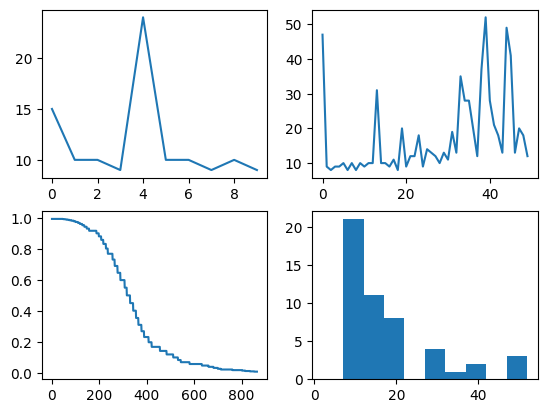

In [258]:
env = CartPoleEnvLinear(n_observations=50, alpha = 0.99)
fig, ax = plt.subplots(2,2)
ax = ax.flat
env.train()
env.test()
# print(np.mean(env.test_metric))
# print(np.median(env.test_metric))
# print(np.quantile(env.metric, [0, 0.25, 0.5, 0.75, .95, .99, 1]))
ax[0].plot(np.array(env.test_metric))
ax[1].plot(env.metric)
ax[2].plot(env.epsilon_greedy_curve)
ax[3].hist(env.metric, bins=10, range=[np.max(env.metric)-50,np.max(env.metric)])

In [58]:
# y = []
# z = []
# r = 100
# alpha = 0.1
# seq = np.arange(-r, r)
# for x in seq:
#     y.append(np.max((1/(1+np.exp(-x*5/r)), 0))) 
#     z.append(alpha*(1/(r-x)))
# # plt.plot(-np.array(y))
# plt.plot(z)

In [211]:
env.w

array([ 2.73299553e-01, -1.98180290e-01, -2.64032683e-01, -1.42649703e+00,
        4.01678488e-01,  4.19563056e-01,  4.22175178e-01,  4.66691877e-01,
        5.08782150e-01,  5.18256752e-01,  7.27223719e-01,  5.31743721e-01,
        7.68886871e-01,  1.43068857e+00, -2.65191550e-45, -1.13848530e-44,
       -2.10929820e-45,  1.13848530e-44, -1.37454317e-46,  2.69179828e-46,
       -1.62795856e-46, -7.91120418e-46,  2.16753903e-45,  1.52984664e-46,
       -2.78050140e-45, -1.82319189e-46, -6.70273178e-46,  2.40394173e-45,
        1.43692882e+00])